In [42]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from config import *
from main import run_trajectory, update_final_layer, update_embedding_size
from simple_decoder_transformer import SimpleDecoderTransformer
from competiclique_the_game import CompetiClique

from copy import deepcopy

builder_states = torch.load("builder_policy_opt.pt")
forbidder_states = torch.load("forbidder_policy_opt.pt")

device = torch.device(DEVICE)

model = SimpleDecoderTransformer(L=LAYERS, H=HEADS, d_e=EMBEDDING_DIM, d_mlp = MLP_DIM, n_tokens=N_TOKENS, n_positions=POSITIONS, n_out=N_OUT).to(device)

game = CompetiClique()

builder_policy = deepcopy(model)#SimpleDecoderTransformer(L = 2, H = 4, d_e = 32, d_mlp = 48)
forbidder_policy = deepcopy(model)#SimpleDecoderTransformer(L = 2, H = 4, d_e = 32, d_mlp = 48)

In [43]:
builder_policy.load_state_dict(builder_states['builder_policy_state_dict'])
forbidder_policy.load_state_dict(forbidder_states['forbidder_policy_state_dict'])

print()

RuntimeError: Error(s) in loading state_dict for SimpleDecoderTransformer:
	size mismatch for vertex_embedding.weight: copying a param with shape torch.Size([10, 64]) from checkpoint, the shape in current model is torch.Size([105, 64]).
	size mismatch for position_embedding.weight: copying a param with shape torch.Size([40, 64]) from checkpoint, the shape in current model is torch.Size([19800, 64]).
	size mismatch for final_linear.weight: copying a param with shape torch.Size([10, 64]) from checkpoint, the shape in current model is torch.Size([105, 64]).
	size mismatch for final_linear.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([105]).

In [ ]:
training_stats = builder_states['training_stats']
builder_discounted_return = [batch_stats['average_builder_return'] for batch_stats, eval_stats in training_stats]
forbidder_discounted_return = [batch_stats['average_forbidder_return'] for batch_stats, eval_stats in training_stats]

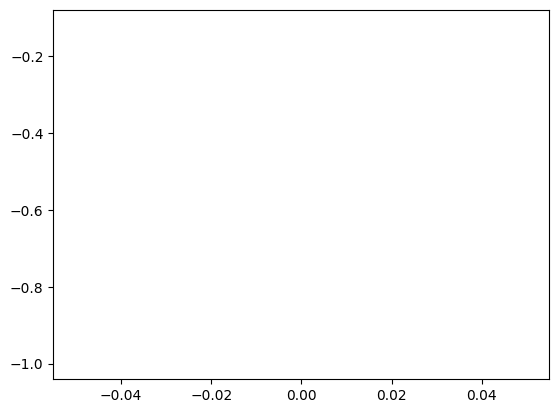

In [ ]:
plt.plot(range(len(builder_discounted_return)), builder_discounted_return)
plt.plot(range(len(forbidder_discounted_return)), forbidder_discounted_return)

nobody_wins
1
clique size goal = 3
edges per builder turn = 1
vertices per forbidder turn = 2


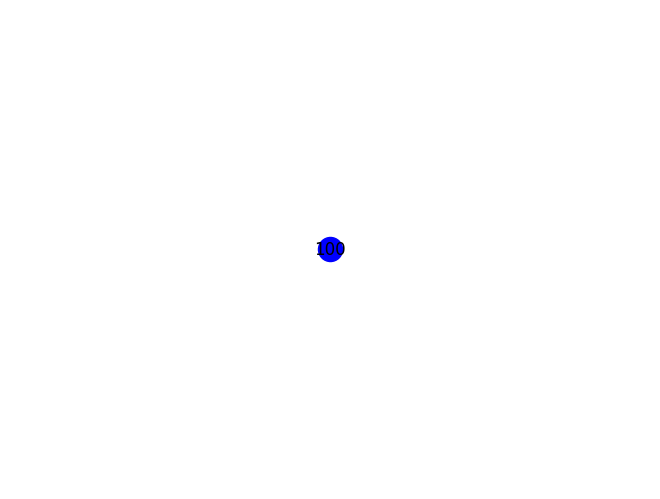

In [41]:
trajectory = None
with torch.no_grad():
    trajectory = run_trajectory(game, builder_policy, forbidder_policy, device, evalu=True)
print(trajectory[-1])
print(trajectory[-5])
print("clique size goal =", game.K)
print("edges per builder turn =", game.M)
print("vertices per forbidder turn =", game.N)

for graph in trajectory[-2]:
    color_map = list('red' if graph.nodes[node]['forbidden'] else 'blue' for node in graph)
    nx.draw(graph, node_color=color_map, with_labels=True)
    plt.show()

In [7]:
trajectory

(deque([tensor([[0.0045, 0.0026, 0.0032, 0.0052, 0.0043, 0.0216, 0.0151, 0.0141, 0.0105,
                 0.0036, 0.0130, 0.0047, 0.0131, 0.0034, 0.0092, 0.0047, 0.0102, 0.0029,
                 0.0224, 0.0100, 0.0046, 0.0059, 0.0081, 0.0031, 0.0349, 0.0156, 0.0131,
                 0.0064, 0.0077, 0.0056, 0.0151, 0.0052, 0.0031, 0.0075, 0.0120, 0.0152,
                 0.0031, 0.0102, 0.0033, 0.0095, 0.0138, 0.0045, 0.0099, 0.0239, 0.0226,
                 0.0043, 0.0151, 0.0101, 0.0062, 0.0139, 0.0104, 0.0181, 0.0052, 0.0034,
                 0.0093, 0.0128, 0.0177, 0.0241, 0.0081, 0.0090, 0.0116, 0.0119, 0.0099,
                 0.0114, 0.0052, 0.0092, 0.0068, 0.0087, 0.0087, 0.0105, 0.0119, 0.0104,
                 0.0158, 0.0045, 0.0037, 0.0061, 0.0069, 0.0081, 0.0143, 0.0151, 0.0038,
                 0.0080, 0.0081, 0.0068, 0.0081, 0.0045, 0.0116, 0.0080, 0.0067, 0.0085,
                 0.0127, 0.0055, 0.0060, 0.0066, 0.0019, 0.0096, 0.0083, 0.0110, 0.0131,
                 0.00